In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras 
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D, Flatten, Dense,BatchNormalization,GlobalAveragePooling2D,Conv2D,Dropout,Flatten,Rescaling,Input
from keras import regularizers
from keras.callbacks import EarlyStopping,ModelCheckpoint

import os
import random
import cv2

2025-06-12 13:07:04.828628: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 13:07:04.836869: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-12 13:07:04.895315: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-12 13:07:04.948699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749744424.999403   56686 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749744425.01

In [5]:
# data_path = r"C:\pastaImagensMangas"
data_path = "../../MangoLeaf"
img_size = (224,224)
batch_size = 32
mode = "rgb"
epochs = 50

In [3]:
def df_maker(path):
    file_paths = []
    labels = []

    folds = os.listdir(path)
    for fold in folds:
        fold_path = os.path.join(path,fold)
        file_list = os.listdir(fold_path)
        for file in file_list:
            file_path = os.path.join(fold_path,file)
            file_paths.append(file_path)
            labels.append(fold)


    file_series = pd.Series(file_paths,name="file_paths")
    label_series = pd.Series(labels,name="labels")

    df = pd.concat([file_series,label_series],axis=1)
    return df

In [6]:
df = df_maker(data_path)

train_df,test_val_df= train_test_split(df ,train_size= 0.8, shuffle= True, random_state= 7, stratify=df["labels"])

test_df,val_df= train_test_split(test_val_df ,train_size= 0.5, shuffle= True, random_state= 7, stratify=test_val_df["labels"])

In [8]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_data = train_datagen.flow_from_dataframe(
    train_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)
test_data = test_datagen.flow_from_dataframe(
    test_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)
val_data = val_datagen.flow_from_dataframe(
    val_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)

Found 3200 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.


In [9]:
g_dict = train_data.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_data)      # get a batch size samples from the generator
# # difference between next iterator and for iterator

In [19]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

def create_lightweight_efficientnet(num_classes, dropout_rate=0.2):
    # EfficientNetB0 é o mais leve da família
    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        input_shape=(224, 224, 3),
        pooling=None,
    )
    
    base_model.trainable = False
    
    # Arquitetura mais leve
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)  # training=False para inference
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    
    # Camada de classificação menor (opcional)
    # x = Dense(64, activation='relu')(x)  # Camada intermediária se necessário
    # x = Dropout(0.1)(x)
    
    outputs = Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs, outputs)
    return model

# Criar modelo otimizado
model_optimized = create_lightweight_efficientnet(len(classes))

model_optimized.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_optimized.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Treinamento e avaliação

In [20]:
# Configurar callbacks para treinamento otimizado
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Criar diretório para modelos se não existir
os.makedirs('../../v2/models', exist_ok=True)

# Configurar callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,  # Aguarda 7 épocas sem melhora
    restore_best_weights=True,
    verbose=1,
    min_delta=0.0001  # Mudança mínima para considerar melhora
)

model_checkpoint = ModelCheckpoint(
    'models/best_efficientnetb0_lightweight.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduz LR pela metade
    patience=4,  # Aguarda 4 épocas sem melhora
    min_lr=1e-7,
    verbose=1,
    cooldown=2  # Aguarda 2 épocas antes de reduzir novamente
)

# Lista de callbacks
callbacks = [early_stopping, model_checkpoint, reduce_lr]

print("Callbacks configurados:")
print(f"- Early Stopping: patience={early_stopping.patience}")
print(f"- Model Checkpoint: salvando em 'models/best_efficientnetb0_lightweight.keras'")
print(f"- Reduce LR: factor={reduce_lr.factor}, patience={reduce_lr.patience}")

Callbacks configurados:
- Early Stopping: patience=7
- Model Checkpoint: salvando em 'models/best_efficientnetb0_lightweight.keras'
- Reduce LR: factor=0.5, patience=4


In [21]:
# Treinar o modelo com callbacks
print("=== INICIANDO TREINAMENTO EFFICIENTNETB0 ===")
print(f"Total de parâmetros: {model_optimized.count_params():,}")
print(f"Parâmetros treináveis: {sum([tf.keras.backend.count_params(w) for w in model_optimized.trainable_weights]):,}")

history = model_optimized.fit(
    train_data,
    validation_data=val_data,
    epochs=50,  # Máximo de épocas (early stopping controlará)
    steps_per_epoch=len(train_data),
    validation_steps=len(val_data),
    callbacks=callbacks,
    verbose=1
)

print(f"\nTreinamento concluído!")
print(f"Parou na época: {len(history.history['loss'])}")
print(f"Melhor val_accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Melhor val_loss: {min(history.history['val_loss']):.4f}")

=== INICIANDO TREINAMENTO EFFICIENTNETB0 ===
Total de parâmetros: 4,059,819
Parâmetros treináveis: 10,248
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6900 - loss: 1.0746
Epoch 1: val_accuracy improved from -inf to 0.98000, saving model to models/best_efficientnetb0_lightweight.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.6916 - loss: 1.0702 - val_accuracy: 0.9800 - val_loss: 0.1971 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9688 - loss: 0.1946
Epoch 2: val_accuracy improved from 0.98000 to 0.98500, saving model to models/best_efficientnetb0_lightweight.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9689 - loss: 0.1943 - val_accuracy: 0.9850 - val_loss: 0.1054 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9839 - loss: 0.1141
Epoch 3: val_accuracy improved from 0.98500 to 0.98750, saving model to models/best_efficientnetb0_lightweight.keras
100/100

In [22]:
_history_dict = history.history
if not _history_dict:
    vals = pd.DataFrame()  # Create an empty DataFrame if history is empty
else:
    # Find the minimum length of all metric lists.
    # This handles cases where some lists might be empty (len=0), making min_length=0.
    # It assumes all values in _history_dict are iterables for which len() is defined (e.g., lists),
    # which is standard for Keras history.history.
    min_length = min(len(v) for v in _history_dict.values())
    
    # Truncate all lists in the history dictionary to this minimum length.
    # If min_length is 0, all lists in processed_history will become empty.
    processed_history = {key: value[:min_length] for key, value in _history_dict.items()}
    
    # Create the DataFrame from the processed history.
    # If processed_history contains empty lists, an empty DataFrame (with columns but no rows) will be created.
    vals = pd.DataFrame(processed_history)
vals = vals.rename(columns={"loss":"Train Loss","val_loss":"Validation Loss","accuracy":"Train Accuracy","val_accuracy":"Validation Accuracy"})

In [23]:
iplot(px.line(data_frame=vals,
              y = ["Train Accuracy","Validation Accuracy"],
              labels={"index":"epochs","value":"accuracy"},
              title = "Accuracy",
              template="plotly_dark"))

In [29]:
# Salvar o modelo
model_optimized.save('models/efficientNetB0.keras')

from tensorflow import keras
# model = keras.models.load_model('modelo_lcnn_versao4.keras')
model = keras.models.load_model('models/efficientNetB0.keras')

In [30]:
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis = 1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

/home/saulolv/PIBIC/TinyML/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 709ms/step


                  precision    recall  f1-score   support

     Anthracnose       1.00      1.00      1.00        50
Bacterial Canker       1.00      1.00      1.00        50
  Cutting Weevil       1.00      1.00      1.00        50
        Die Back       1.00      1.00      1.00        50
      Gall Midge       1.00      1.00      1.00        50
         Healthy       1.00      1.00      1.00        50
  Powdery Mildew       0.98      1.00      0.99        50
     Sooty Mould       1.00      0.98      0.99        50

        accuracy                           1.00       400
       macro avg       1.00      1.00      1.00       400
    weighted avg       1.00      1.00      1.00       400



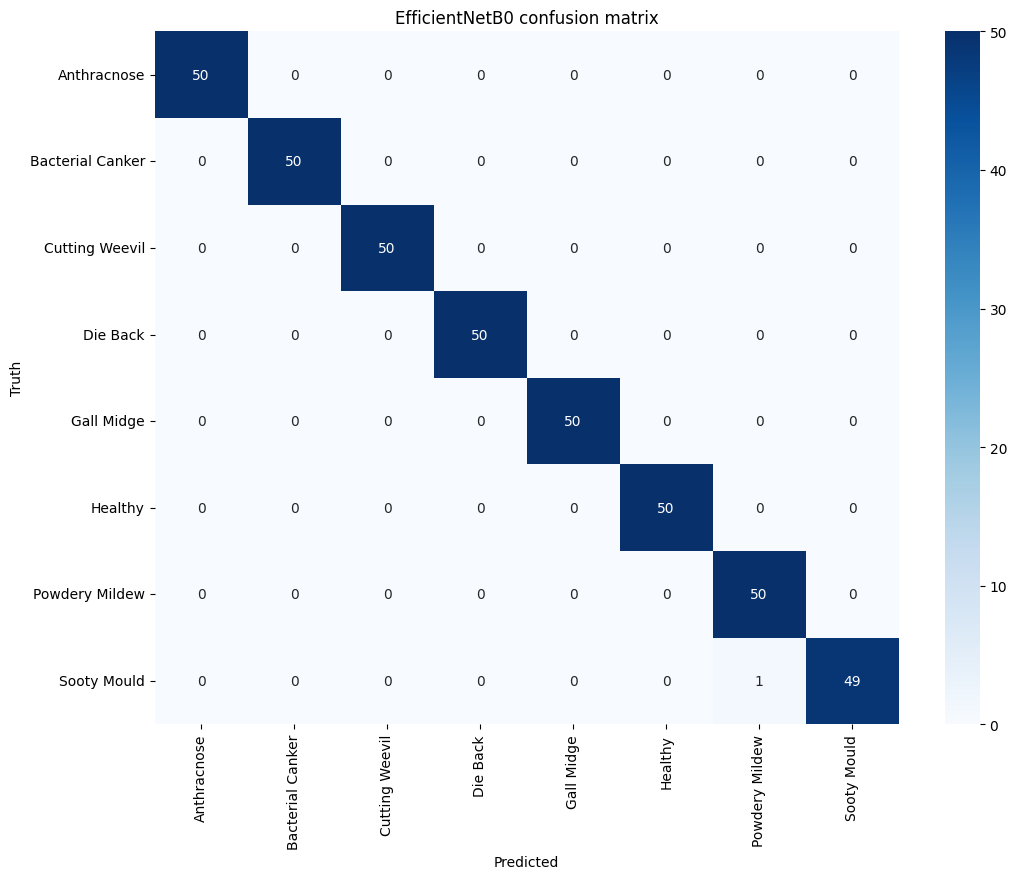

In [31]:
print(classification_report(y_true,y_pred, target_names=class_labels))

plt.figure(figsize = (12,9))
cm = confusion_matrix(y_true, y_pred)
# sns.heatmap(cm, annot=True,fmt='d',cmap= plt.cm.Blues)
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("EfficientNetB0 confusion matrix")
plt.show()